In [1]:
%%capture --no-stderr
!pip install -q langgraph langchain-mistralai langchain_huggingface

In [2]:
import getpass
import os
def _set_env(var:str):
    if not os.environ.get(var):
        os.environ[var]=getpass.getpass(f"{var}:")

_set_env("Mistral_API_KEY")        

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [24]:
from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(model="mistral-large-latest",
    temperature=0,
    max_retries=10)


# def chatbot(state: State):
#     return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
# graph_builder.add_node("chatbot", chatbot)

In [25]:
# graph_builder.add_edge(START,"chatbot")
# graph_builder.add_edge("chatbot",END)

In [26]:
# graph=graph_builder.compile()

In [27]:
# from IPython.display import Image,display
# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception:
#     pass


In [31]:
# def stream_graph_updates(user_input: str):
#     for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)


# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break
#         stream_graph_updates(user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about the Reinforcement Learning"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
        # break

In [29]:
%%capture --no-stderr
!pip install -U  tavily-python langchain_community

In [12]:
_set_env("TAVILY_API_KEY")

In [32]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool=TavilySearchResults(max_results=10)
tools=[tool]
tool.invoke("Top 10 question in Electricity for jee advance")

[{'title': 'JEE Advanced Electric Current Important Questions - Vedantu',
  'url': 'https://www.vedantu.com/jee-advanced/physics-electric-current-important-questions',
  'content': 'Keep solving, and keep gaining confidence in your ability!\n\nFAQs on JEE Advanced Electric Current Important Questions\n\n1. How important is Electric Current for the JEE Examination?\n\nCurrent is really an essential as well as fundamental element within electronic and electrical technology. The current that flows in a circuit must be used in varied methods from generating heat to causing circuits to switch and information is stored within an integrated circuit. [...] The total marks for JEE Advanced have calculated 366 Marks. Every paper; Paper I and II carry a total of 183 Marks. The question paper comprises objective-type questions that consist of MCQs (Multiple Choice Questions) as well as Numerical type questions. The question paper is set in English and Hindi only, it is up to the student in which l

In [34]:
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot-master", chatbot)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [35]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [36]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot-master")
graph_builder.add_edge(START, "chatbot-master")
graph = graph_builder.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


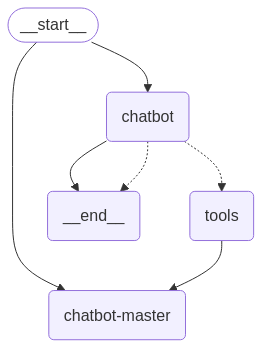

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "\"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: "Zero Dark Thirty" is a 2012 American thriller film directed by Kathryn Bigelow and written by Mark Boal. The film dramatizes the decade-long hunt for Osama bin Laden, the leader of al-Qaeda, after the September 11 attacks. The title, "Zero Dark Thirty," is a military term for 30 minutes after midnight.

The movie focuses on a CIA operative named Maya (played by Jessica Chastain) who is obsessed with finding bin Laden. The narrative covers various intelligence operations, including the use of enhanced interrogation techniques (torture), and culminates in the Navy SEAL Team 6 raid on bin Laden's compound in Abbottabad, Pakistan, on May 2, 2011.

"Zero Dark Thirty" received critical acclaim for its direction, screenplay, and performances, particularly Chastain's portrayal of Maya. The film was nominated for several awards, including five Academy Awards, and won the Oscar for Best Sound Editing. However, it also sparked controversy due to its depiction of torture and the debate